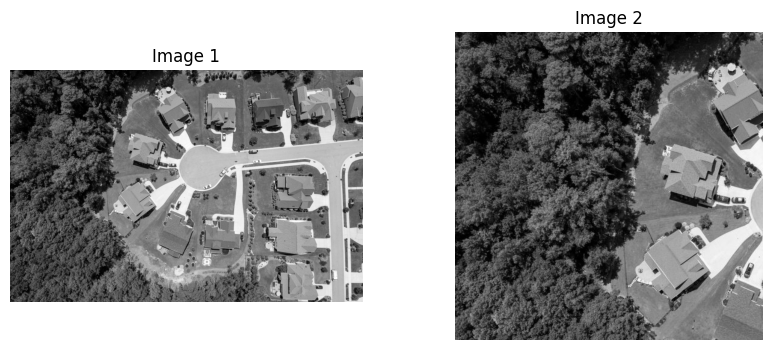

In [1]:
# CELL 01
# 📦 IMPORTS (No OpenCV used)
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import maximum_filter
import random



# 📸 Load grayscale images
def load_image_gray(path):
    img = Image.open(path).convert("L")
    return np.array(img, dtype=np.float32) / 255.0

# 🔽 Upload your images here (you can use any method in Colab)
img1 = load_image_gray("/content/Sample1.jpg")
img2 = load_image_gray("/content/sample3.jpg")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.title("Image 1")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.title("Image 2")
plt.axis('off')
plt.show()

🌀 [f=9] MaxResp: 5.02e+02 | Thresh: 1.00e+00
🌀 [f=15] MaxResp: 2.37e+03 | Thresh: 4.73e+00
🌀 [f=21] MaxResp: 7.15e+03 | Thresh: 1.43e+01
✅ Keypoints Returned: 1000
🌀 [f=9] MaxResp: 4.64e+02 | Thresh: 9.27e-01
🌀 [f=15] MaxResp: 2.02e+03 | Thresh: 4.04e+00
🌀 [f=21] MaxResp: 6.31e+03 | Thresh: 1.26e+01
✅ Keypoints Returned: 1000


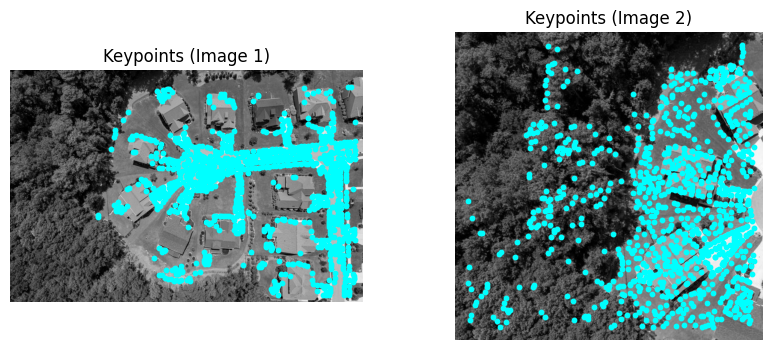

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter

# --- SURF-style Hessian Keypoint Detector ---
def compute_integral_image(img):
    return img.cumsum(axis=0).cumsum(axis=1)

def box_sum(ii, top, left, height, width):
    bottom = top + height
    right = left + width

    h, w = ii.shape
    bottom = min(bottom, h - 1)
    right = min(right, w - 1)

    total = ii[bottom, right]
    if top > 0:
        total -= ii[top - 1, right]
    if left > 0:
        total -= ii[bottom, left - 1]
    if top > 0 and left > 0:
        total += ii[top - 1, left - 1]
    return total

def hessian_response(ii, y, x, size):
    s = size // 3
    Dxx = box_sum(ii, y - s//2, x - s, s, 2*s) - 3 * box_sum(ii, y - s//2, x - s//2, s, s)
    Dyy = box_sum(ii, y - s, x - s//2, 2*s, s) - 3 * box_sum(ii, y - s//2, x - s//2, s, s)
    Dxy = box_sum(ii, y - s, x - s, s, s) + box_sum(ii, y, x, s, s) \
        - box_sum(ii, y - s, x, s, s) - box_sum(ii, y, x - s, s, s)
    return Dxx * Dyy - 0.81 * Dxy**2

def detect_keypoints(img, max_points=1000, verbose=True):
    ii = compute_integral_image(img)
    keypoints = []
    sizes = [9, 15, 21]  # Multi-scale (SURF-style)

    for f in sizes:
        responses = np.zeros_like(img)
        for y in range(f, img.shape[0] - f):
            for x in range(f, img.shape[1] - f):
                resp = hessian_response(ii, y, x, f)
                responses[y, x] = resp

        max_resp = responses.max()
        thresh = 0.002 * max_resp  # Slightly stricter
        if verbose:
            print(f"🌀 [f={f}] MaxResp: {max_resp:.2e} | Thresh: {thresh:.2e}")

        # Non-maximum suppression
        mask = (responses == maximum_filter(responses, size=5))
        ys, xs = np.where((responses > thresh) & mask)
        for y, x in zip(ys, xs):
            keypoints.append((y, x, f, responses[y, x]))

    # Sort by response strength
    keypoints = sorted(keypoints, key=lambda pt: pt[3], reverse=True)

    if max_points is not None:
        keypoints = keypoints[:max_points]

    final_kp = [(y, x) for y, x, _, _ in keypoints]
    if verbose:
        print(f"✅ Keypoints Returned: {len(final_kp)}")
    return np.array(final_kp)

# 🔧 Utility to visualize
def draw_keypoints(img, keypoints, title="Detected Keypoints"):
    plt.imshow(img, cmap='gray')
    plt.scatter([x for y, x in keypoints], [y for y, x in keypoints], s=10, c='cyan')
    plt.title(title)
    plt.axis('off')

# 🌟 Run on any input grayscale images img1, img2
kp1 = detect_keypoints(img1)  # No fixed number
kp2 = detect_keypoints(img2)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
draw_keypoints(img1, kp1, "Keypoints (Image 1)")
plt.subplot(1, 2, 2)
draw_keypoints(img2, kp2, "Keypoints (Image 2)")
plt.show()


✅ Descriptors: 1000 (img1) / 1000 (img2)
🔗 Final Matches: 118


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


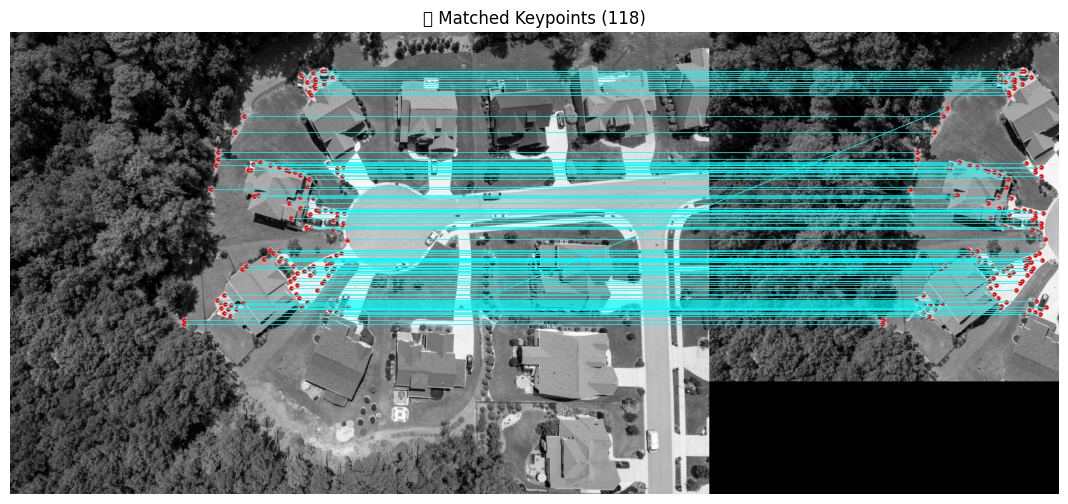

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 🧬 BRIEF descriptor generator (generalized!)
def generate_brief_descriptors(img, keypoints, patch_size=31, n_bits=256, seed=42):
    np.random.seed(seed)  # consistent test pairs across images
    half = patch_size // 2
    h, w = img.shape

    # Generate consistent test pairs
    compareX = np.random.randint(-half, half + 1, (n_bits, 2))
    compareY = np.random.randint(-half, half + 1, (n_bits, 2))

    descriptors = []
    safe_keypoints = []

    for y, x in keypoints:
        if x - half < 0 or x + half >= w or y - half < 0 or y + half >= h:
            continue
        desc = []
        for (dy1, dx1), (dy2, dx2) in zip(compareX, compareY):
            p1 = img[y + dy1, x + dx1]
            p2 = img[y + dy2, x + dx2]
            desc.append(1 if p1 < p2 else 0)
        descriptors.append(desc)
        safe_keypoints.append((y, x))

    return np.array(descriptors, dtype=np.uint8), np.array(safe_keypoints)

# 🧲 Match descriptors using Hamming distance
def hamming_distance(desc1, desc2):
    return np.sum(desc1 != desc2)

def match_descriptors(descs1, descs2, ratio_thresh=0.75):
    matches = []
    for i, d1 in enumerate(descs1):
        dists = np.sum(descs2 != d1, axis=1)
        sorted_idx = np.argsort(dists)
        best, second_best = dists[sorted_idx[0]], dists[sorted_idx[1]]
        if best < ratio_thresh * second_best:
            matches.append((i, sorted_idx[0], best))
    return matches

# 🎯 Filter top N matches or with distance threshold
def filter_matches(matches, top_k=200, max_dist=None):
    matches = sorted(matches, key=lambda m: m[2])
    if max_dist is not None:
        matches = [m for m in matches if m[2] <= max_dist]
    if top_k is not None:
        matches = matches[:top_k]
    return matches

# 🎨 Draw match lines (OpenCV-style visualization)
def draw_matches(img1, img2, kp1, kp2, matches):
    h1, w1 = img1.shape
    h2, w2 = img2.shape

    # Normalize to uint8 (0-255) if needed
    if img1.dtype != np.uint8:
        img1 = (255 * img1).clip(0, 255).astype(np.uint8)
    if img2.dtype != np.uint8:
        img2 = (255 * img2).clip(0, 255).astype(np.uint8)

    canvas = np.zeros((max(h1, h2), w1 + w2), dtype=np.uint8)
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:] = img2

    plt.figure(figsize=(14, 6))
    plt.imshow(canvas, cmap='gray')
    for i1, i2, _ in matches:
        y1, x1 = kp1[i1]
        y2, x2 = kp2[i2]
        plt.plot([x1, x2 + w1], [y1, y2], color='cyan', linewidth=0.5)
        plt.scatter([x1, x2 + w1], [y1, y2], color='red', s=5)
    plt.title(f"🔗 Matched Keypoints ({len(matches)})")
    plt.axis('off')
    plt.show()

# Generalized pipeline
desc1, safe_kp1 = generate_brief_descriptors(img1, kp1)
desc2, safe_kp2 = generate_brief_descriptors(img2, kp2)

print(f"✅ Descriptors: {len(desc1)} (img1) / {len(desc2)} (img2)")

# Match & filter
raw_matches = match_descriptors(desc1, desc2)
strong_matches = filter_matches(raw_matches, top_k=300, max_dist=64)

print(f"🔗 Final Matches: {len(strong_matches)}")

# Visualize
draw_matches(img1, img2, safe_kp1, safe_kp2, strong_matches)


⚠️ Only 137 good matches found. Fallback: Top-500
🎯 Final Matches: 500


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


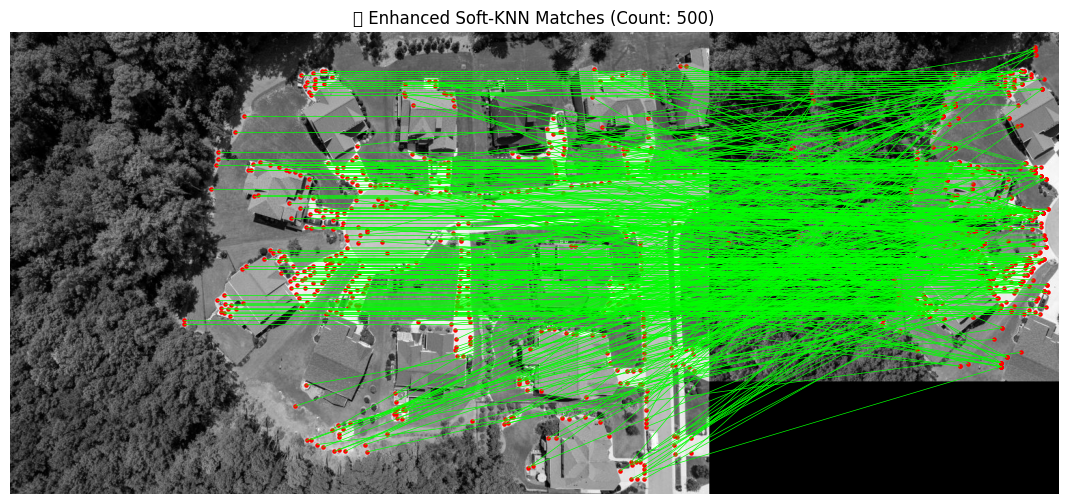

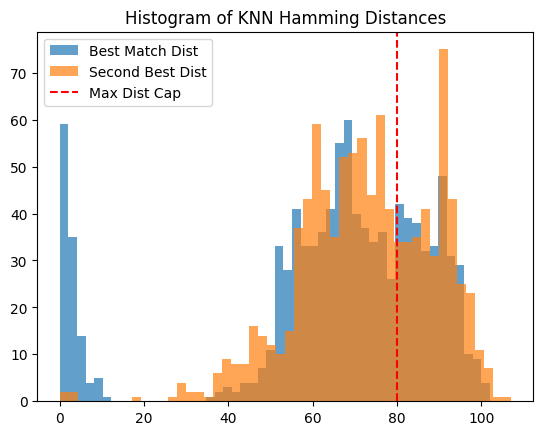

📊 Min: 0.0, Max: 102.0, Avg: 64.6


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- Hamming Distance ---
def hamming_distance(desc1, desc2):
    return np.sum(desc1 != desc2)

# --- KNN Matching ---
def knn_match_descriptors(descs1, descs2, k=2):
    knn_matches = []
    for i, d1 in enumerate(descs1):
        distances = np.array([hamming_distance(d1, d2) for d2 in descs2])
        topk_idx = np.argsort(distances)[:k]
        topk_dists = distances[topk_idx]
        knn_matches.append((i, topk_idx, topk_dists))
    return knn_matches

# --- Soft Ratio Test ---
def soft_ratio_test(knn_matches, ratio_thresh=0.85, max_dist=80):
    good_matches = []
    matched_in_2 = set()
    for i1, idxs, dists in knn_matches:
        if len(dists) < 2:
            continue
        d0, d1 = dists[0], dists[1]
        if d0 <= max_dist and d0 < ratio_thresh * d1:
            if idxs[0] not in matched_in_2:
                good_matches.append((i1, idxs[0], d0))
                matched_in_2.add(idxs[0])
    return good_matches

# --- Draw Matches ---
def draw_matches(img1, img2, kp1, kp2, matches, title="🔗 KNN-Ratio Matched Keypoints"):
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    canvas = np.zeros((max(h1, h2), w1 + w2))
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:] = img2

    plt.figure(figsize=(14, 6))
    plt.imshow(canvas, cmap='gray')
    for i1, i2, dist in matches:
        y1, x1 = kp1[i1]
        y2, x2 = kp2[i2]
        plt.plot([x1, x2 + w1], [y1, y2], color='lime', linewidth=0.5)
        plt.scatter([x1, x2 + w1], [y1, y2], color='red', s=5)
    plt.title(f"{title} (Count: {len(matches)})")
    plt.axis('off')
    plt.show()

# --- Run Matching Pipeline ---
knn_matches = knn_match_descriptors(desc1, desc2, k=2)
knn_ratio_matches = soft_ratio_test(knn_matches, ratio_thresh=0.85, max_dist=80)

# --- Fallback if Needed ---
MIN_MATCHES = 500
if len(knn_ratio_matches) < MIN_MATCHES:
    print(f"⚠️ Only {len(knn_ratio_matches)} good matches found. Fallback: Top-{MIN_MATCHES}")
    fallback = []
    for i1, idxs, dists in knn_matches:
        if len(dists) >= 1 and dists[0] <= 100:
            fallback.append((i1, idxs[0], dists[0]))
    fallback = sorted(fallback, key=lambda x: x[2])[:MIN_MATCHES]
    knn_ratio_matches = fallback

print(f"🎯 Final Matches: {len(knn_ratio_matches)}")
draw_matches(img1, img2, safe_kp1, safe_kp2, knn_ratio_matches, title="🎯 Enhanced Soft-KNN Matches")

# --- Histogram (Optional Insight) ---
all_dists = []
for _, _, dists in knn_matches:
    if len(dists) == 2:
        all_dists.append((dists[0], dists[1]))

if all_dists:
    all_dists = np.array(all_dists)
    plt.hist(all_dists[:, 0], bins=50, alpha=0.7, label='Best Match Dist')
    plt.hist(all_dists[:, 1], bins=50, alpha=0.7, label='Second Best Dist')
    plt.axvline(80, color='red', linestyle='--', label='Max Dist Cap')
    plt.title("Histogram of KNN Hamming Distances")
    plt.legend()
    plt.show()
    print(f"📊 Min: {np.min(all_dists[:,0]):.1f}, Max: {np.max(all_dists[:,0]):.1f}, Avg: {np.mean(all_dists[:,0]):.1f}")


✅ RANSAC Inliers: 134 / 500


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


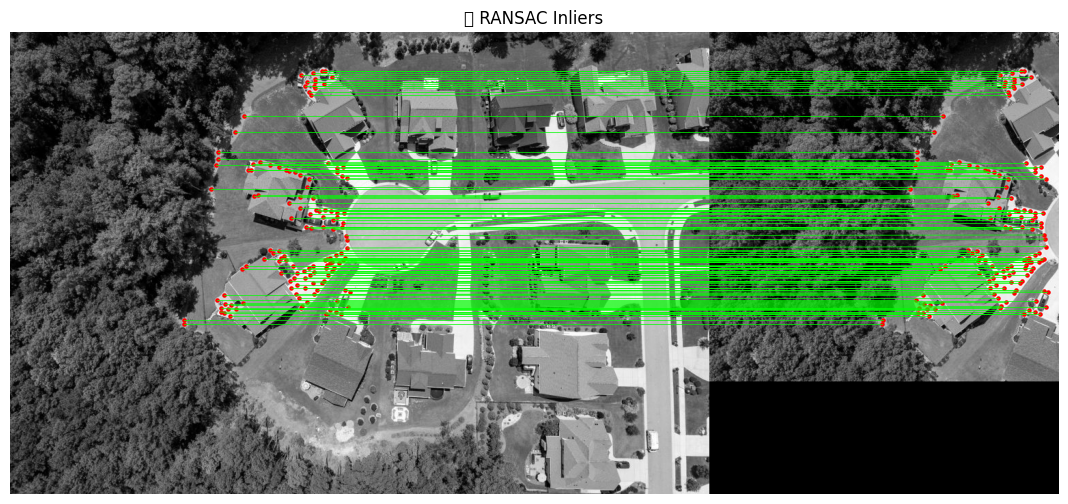

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

# 🧮 Compute homography from 4+ point correspondences using DLT
def compute_homography(pts1, pts2):
    A = []
    for (y1, x1), (y2, x2) in zip(pts1, pts2):
        A.append([-x1, -y1, -1, 0, 0, 0, x2 * x1, x2 * y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2 * x1, y2 * y1, y2])
    A = np.array(A)
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    return H / H[2, 2]

# 📐 Apply homography to points
def apply_homography(H, pts):
    pts_h = np.hstack([pts[:, [1, 0]], np.ones((pts.shape[0], 1))])  # (x, y, 1)
    projected = (H @ pts_h.T).T
    projected /= projected[:, [2]]
    return projected[:, :2][:, ::-1]  # back to (y, x)

# 🔍 Custom RANSAC
def ransac_homography(kp1, kp2, matches, num_iters=1000, threshold=3.0):
    if len(matches) < 4:
        return None, []

    best_H = None
    best_inliers = []

    for _ in range(num_iters):
        sample = random.sample(matches, 4)
        pts1 = [kp1[i1] for i1, i2, _ in sample]
        pts2 = [kp2[i2] for i1, i2, _ in sample]

        try:
            H = compute_homography(pts1, pts2)
        except np.linalg.LinAlgError:
            continue

        all_pts1 = np.array([kp1[i1] for i1, i2, _ in matches])
        all_pts2 = np.array([kp2[i2] for i1, i2, _ in matches])
        projected_pts2 = apply_homography(H, all_pts1)

        errors = np.linalg.norm(projected_pts2 - all_pts2, axis=1)
        inliers = [matches[i] for i in range(len(errors)) if errors[i] < threshold]

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_H = H

    return best_H, best_inliers

# 🖼️ Draw inlier matches
def draw_matches(img1, img2, kp1, kp2, matches, title="✅ RANSAC Inliers"):
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    canvas = np.zeros((max(h1, h2), w1 + w2))
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:] = img2

    plt.figure(figsize=(14, 6))
    plt.imshow(canvas, cmap='gray')
    for i1, i2, _ in matches:
        y1, x1 = kp1[i1]
        y2, x2 = kp2[i2]
        plt.plot([x1, x2 + w1], [y1, y2], color='lime', linewidth=0.5)
        plt.scatter([x1, x2 + w1], [y1, y2], color='red', s=5)
    plt.title(title)
    plt.axis('off')
    plt.show()

# 🚀 Run RANSAC purification
H, ransac_inliers = ransac_homography(safe_kp1, safe_kp2, knn_ratio_matches, num_iters=1000, threshold=3.0)
print(f"✅ RANSAC Inliers: {len(ransac_inliers)} / {len(knn_ratio_matches)}")

# 🖼️ Draw only inliers
draw_matches(img1, img2, safe_kp1, safe_kp2, ransac_inliers, title="✅ RANSAC Inliers")


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


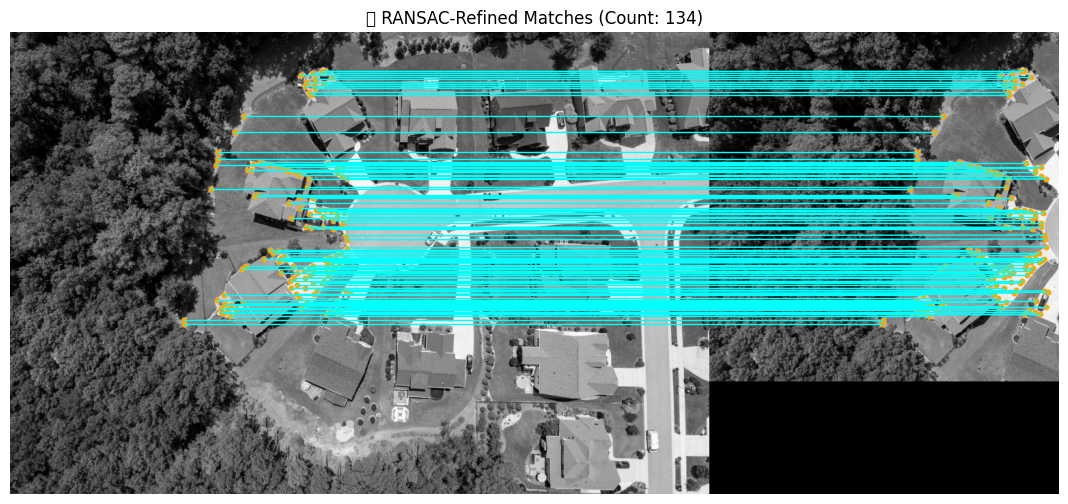

In [6]:
def draw_inlier_matches(img1, img2, kp1, kp2, inlier_matches, title="✅ Final Inlier Matches"):
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    canvas = np.zeros((max(h1, h2), w1 + w2))
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:] = img2

    plt.figure(figsize=(14, 6))
    plt.imshow(canvas, cmap='gray')

    for i1, i2, _ in inlier_matches:
        y1, x1 = kp1[i1]
        y2, x2 = kp2[i2]
        plt.plot([x1, x2 + w1], [y1, y2], color='cyan', linewidth=1)
        plt.scatter([x1, x2 + w1], [y1, y2], color='orange', s=10)

    plt.title(f"{title} (Count: {len(inlier_matches)})")
    plt.axis('off')
    plt.show()

# 🖼️ Visualize refined RANSAC inliers
draw_inlier_matches(img1, img2, safe_kp1, safe_kp2, ransac_inliers, title="🌟 RANSAC-Refined Matches")


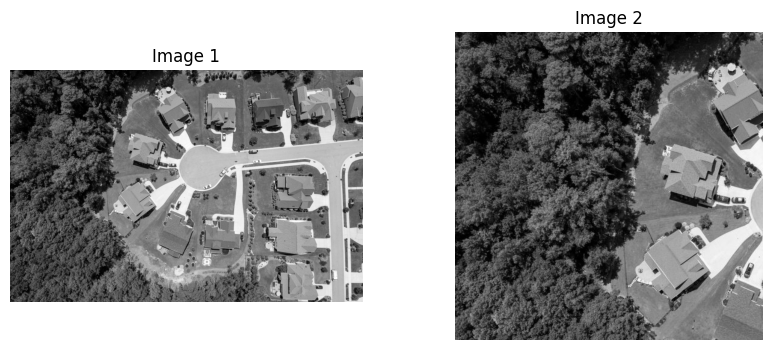


📌 Homography matrix (H):
 [[ 1.00000000e+00  1.38435766e-11 -1.32420749e-08]
 [ 1.31649308e-11  1.00000000e+00 -7.66557199e-09]
 [ 4.64395489e-14  2.92290328e-14  1.00000000e+00]]

🔍 Image 1 shape: (677, 1024)
🔍 Image 2 shape: (512, 512)
🧾 Canvas size: (678, 1025), Offset: [np.int64(1), np.int64(1)]
📐 Corner bounds: x:[-1, 1024], y:[-1, 677]
[DEBUG] Warp ok at (1,1) → src: (0.00,0.00) → val: 0.14
[DEBUG] Warp ok at (2,1) → src: (1.00,0.00) → val: 0.13
[DEBUG] Warp ok at (3,1) → src: (2.00,0.00) → val: 0.11
[DEBUG] Warp ok at (4,1) → src: (3.00,0.00) → val: 0.13
[DEBUG] Warp ok at (5,1) → src: (4.00,0.00) → val: 0.09
✅ Warped image contains valid pixels.
[DEBUG] Warp ok at (1,1) → src: (0.00,0.00) → val: 0.14
[DEBUG] Warp ok at (2,1) → src: (1.00,0.00) → val: 0.13
[DEBUG] Warp ok at (3,1) → src: (2.00,0.00) → val: 0.11
[DEBUG] Warp ok at (4,1) → src: (3.00,0.00) → val: 0.13
[DEBUG] Warp ok at (5,1) → src: (4.00,0.00) → val: 0.09
✅ Warped image contains valid pixels.


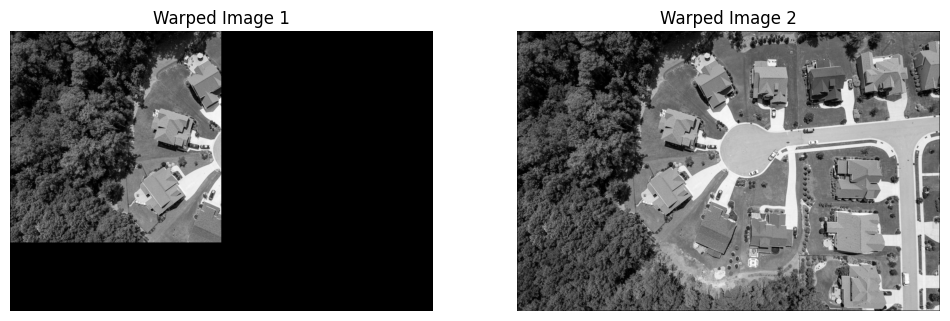

📊 Final panorama max value: 255
🧪 Unique values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 2

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127748 (\N{SUNRISE OVER MOUNTAINS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128736 (\N{HAMMER AND WRENCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


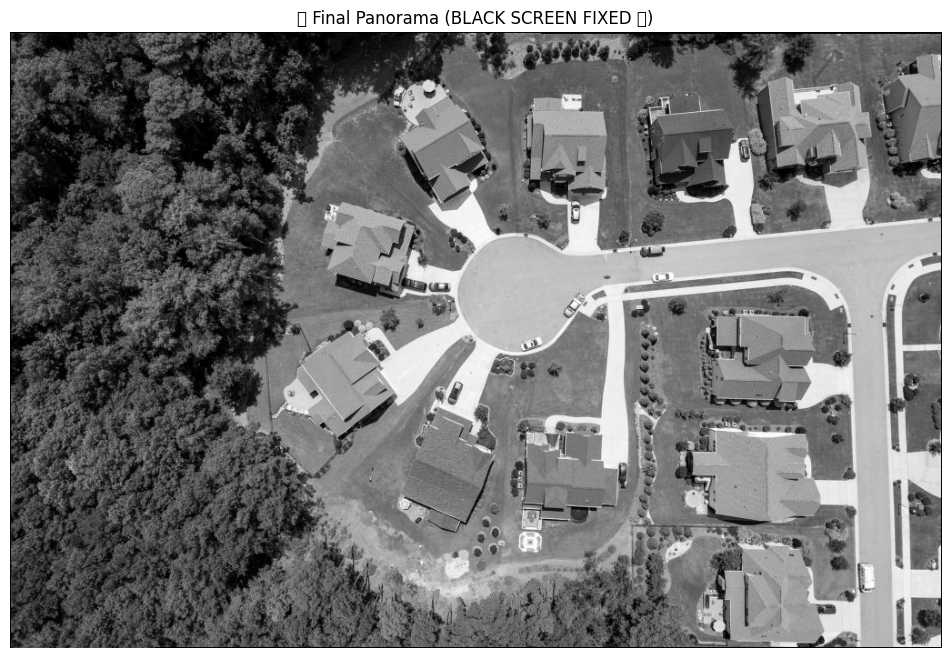

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 🧮 Homography projection for individual points
def apply_homography_single(pt, H):
    pt_h = np.array([pt[0], pt[1], 1.0])
    transformed = H @ pt_h
    return transformed[:2] / transformed[2]

# 🧭 Manual bilinear warp with debugging
def warp_image_manual(img, H, offset, canvas_h, canvas_w):
    warped = np.zeros((canvas_h, canvas_w), dtype=np.float32)
    H_inv = np.linalg.inv(H)

    sample_debug = 0
    for y in range(canvas_h):
        for x in range(canvas_w):
            pt = np.array([x - offset[1], y - offset[0]])  # (x, y)
            src = apply_homography_single(pt, H_inv)
            sx, sy = src

            if 0 <= sy < img.shape[0] - 1 and 0 <= sx < img.shape[1] - 1:
                x0, y0 = int(sx), int(sy)
                dx, dy = sx - x0, sy - y0

                try:
                    val = (
                        img[y0, x0] * (1 - dx) * (1 - dy) +
                        img[y0, x0+1] * dx * (1 - dy) +
                        img[y0+1, x0] * (1 - dx) * dy +
                        img[y0+1, x0+1] * dx * dy
                    )
                    warped[y, x] = val

                    if sample_debug < 5:
                        print(f"[DEBUG] Warp ok at ({x},{y}) → src: ({sx:.2f},{sy:.2f}) → val: {val:.2f}")
                        sample_debug += 1
                except:
                    print(f"[ERROR] Failed bilinear at src ({sx:.2f}, {sy:.2f})")

    if np.all(warped == 0):
        print("⚠️ All warped pixels are zero!")
    else:
        print("✅ Warped image contains valid pixels.")
    return warped

# 💫 Blend using masks
def blend_manual(img1_warped, img2_warped):
    mask1 = (img1_warped > 0).astype(np.float32)
    mask2 = (img2_warped > 0).astype(np.float32)

    total_mask = mask1 + mask2
    total_mask[total_mask == 0] = 1

    blended = (img1_warped + img2_warped) / total_mask
    blended = np.clip(blended * 255.0, 0, 255).astype(np.uint8)
    return blended

# 🧵 Final stitching function
def stitch_images_manual(img1, img2, H21):
    h1, w1 = img1.shape
    h2, w2 = img2.shape

    corners_img2 = np.array([[0, 0], [0, h2], [w2, 0], [w2, h2]], dtype=np.float32)
    warped_corners_img2 = np.array([apply_homography_single(p, H21) for p in corners_img2])
    corners_img1 = np.array([[0, 0], [0, h1], [w1, 0], [w1, h1]])

    all_corners = np.vstack((corners_img1, warped_corners_img2))
    x_min, y_min = np.floor(all_corners.min(axis=0)).astype(int)
    x_max, y_max = np.ceil(all_corners.max(axis=0)).astype(int)

    offset = [-y_min, -x_min]
    canvas_h, canvas_w = y_max - y_min, x_max - x_min

    print(f"\n🔍 Image 1 shape: {img1.shape}")
    print(f"🔍 Image 2 shape: {img2.shape}")
    print(f"🧾 Canvas size: ({canvas_h}, {canvas_w}), Offset: {offset}")
    print(f"📐 Corner bounds: x:[{x_min}, {x_max}], y:[{y_min}, {y_max}]")

    # Warp both images
    identity_H = np.eye(3)
    # img1_warped = warp_image_manual(img1, identity_H, offset, canvas_h, canvas_w)
    img1_warped = warp_image_manual(img2, identity_H, offset, canvas_h, canvas_w)
    img2_warped = warp_image_manual(img1, H21, offset, canvas_h, canvas_w)

    # Show warped canvases
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img1_warped, cmap='gray')
    plt.title("Warped Image 1")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2_warped, cmap='gray')
    plt.title("Warped Image 2")
    plt.axis('off')
    plt.show()

    # Final blend
    final_panorama = blend_manual(img1_warped, img2_warped)
    return final_panorama

# -----------------------------------------
# 💥 START EXECUTION & DEBUG
# -----------------------------------------

# 🔍 Sanity check input images
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.title("Image 2")
plt.axis('off')
plt.show()

# 🔍 Print homography
print("\n📌 Homography matrix (H):\n", H)

# 🧵 Stitch
final_panorama = stitch_images_manual(img1, img2, H)

# 🧪 Check result stats
print("📊 Final panorama max value:", final_panorama.max())
print("🧪 Unique values:", np.unique(final_panorama))

# 🖼️ Show result
plt.figure(figsize=(16, 8))
plt.imshow(final_panorama, cmap='gray')  # no *255!
plt.title("🌄 Final Panorama (BLACK SCREEN FIXED 🛠️)")
plt.axis('off')
plt.show()
